In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/home/ludo/ownCloud/Programmes/quarto/biomaths_www':
  os.chdir(r'/home/ludo/ownCloud/Programmes/quarto/biomaths_www')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


/tmp/ipykernel_391817/3972549079.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"/home/ludo/miniconda3/lib/python3.10/importlib/_bootstrap.py": 1669299894.0, "/home/ludo/miniconda3/lib/python3.10/importlib/_bootstrap_external.py": 1669299894.0, "/home/ludo/miniconda3/lib/python3.10/codecs.py": 1669299894.0, "/home/ludo/miniconda3/lib/python3.10/encodings/aliases.py": 1669299894.0, "/home/ludo/miniconda3/lib/python3.10/encodings/__init__.py": 1669299894.0, "/home/ludo/miniconda3/lib/python3.10/encodings/utf_8.py": 1669299894.0, "/home/ludo/miniconda3/lib/python3.10/abc.py": 1669299894.0, "/home/ludo/miniconda3/lib/python3.10/io.py": 1669299894.0, "/home/ludo/miniconda3/lib/python3.10/stat.py": 1669299894.0, "/home/ludo/miniconda3/lib/python3.10/_collections_abc.py": 1669299894.0, "/home/ludo/miniconda3/lib/python3.10/genericpath.py": 1669299894.0, "/home/ludo/miniconda3/lib/python3.10/posixpath.py": 1669299894.0, "/home/ludo/miniconda3/lib/python3.10/os.py": 1669299894.0, "/home/ludo/miniconda3/lib/python3.10/_sitebuiltins.py": 1669299894.0, "/home/ludo/miniconda3

In [2]:
#| code-fold: true
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [3]:
E_s = 0.2
E_x = 0.85
T_s = 10.0
T_x = 9.0

params_Evar = np.array([E_s, E_x, T_s, T_x])

In [4]:
def Evar(t, params):
    E_s, E_x, T_s, T_x = params
    if t <= T_s or t > T_s+T_x:
        return E_s
    else:
        return E_x

In [5]:
#| code-fold: true

## paramètres
r = 1.0       # taux de croissance intrinsèque
epsilon = 2.0 # seuil de Allee
K = 10.0      # capacité de charge
params_allee = np.array([r, K, epsilon])

## tspan
t_0 = 0.0           
t_fin = 30.0        
pas_t = 0.01        
tspan = np.arange(t_0, t_fin, pas_t)

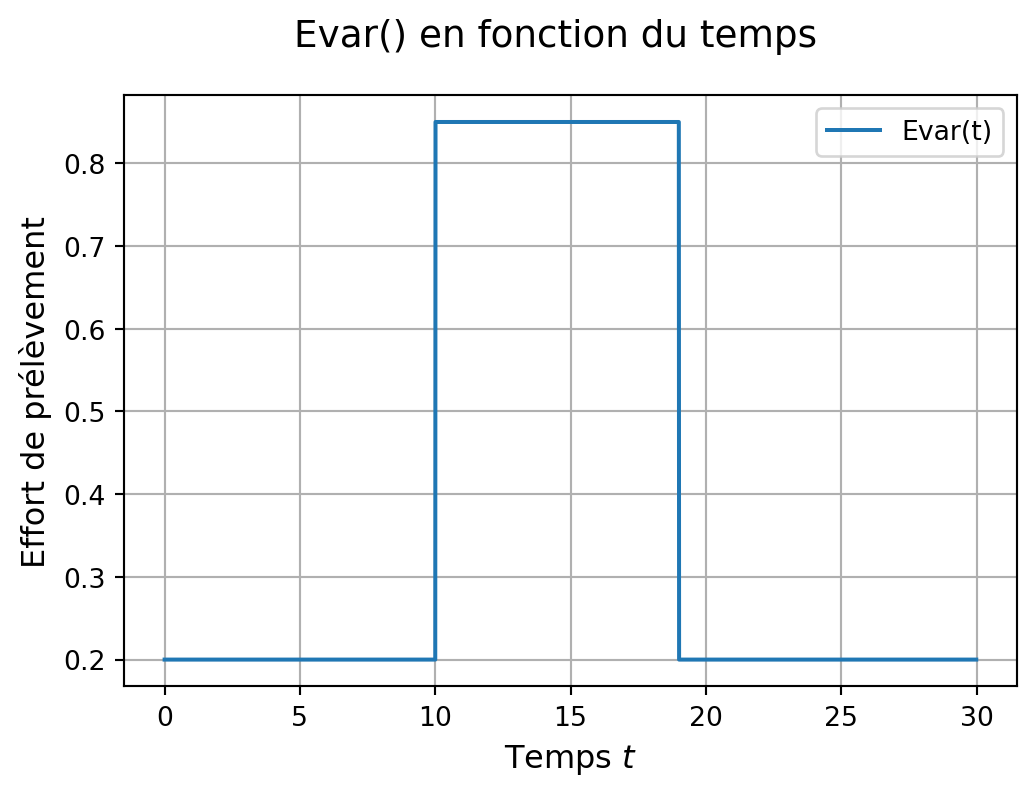

In [6]:
#| label: fig-evar
#| code-fold: true
#| fig-cap: représentation de la fonction `Evar()` en fonction du temps

fig, ax = plt.subplots(1, 1, figsize=(6,4))  
fig.suptitle('Evar() en fonction du temps',
              va='top', fontsize='14')

ax.plot(tspan, [Evar(t, params_Evar) for t in tspan], label = "Evar(t)")

## axes / légendes / grille
ax.legend(fontsize='10')
ax.set_xlabel('Temps $t$', fontsize='12')
ax.set_ylabel('Effort de prélèvement', fontsize='12')
ax.grid()

In [7]:
def model_alleePrelev(etat, t, params, paramsEv): 
    x = etat              # on recupere l'etat
    r, K, epsilon = params     # on récupère les paramètres
    xdot = r*x*(x/epsilon-1)*(1-x/K) - Evar(t, paramsEv)*x    # la derivee 
    return xdot    

In [8]:
## condition initiale
x0 = K

## intégration
int_alleePrelev = odeint(model_alleePrelev,
                         x0,
                         tspan,
                         args=(params_allee, params_Evar),
                         hmax=pas_t)

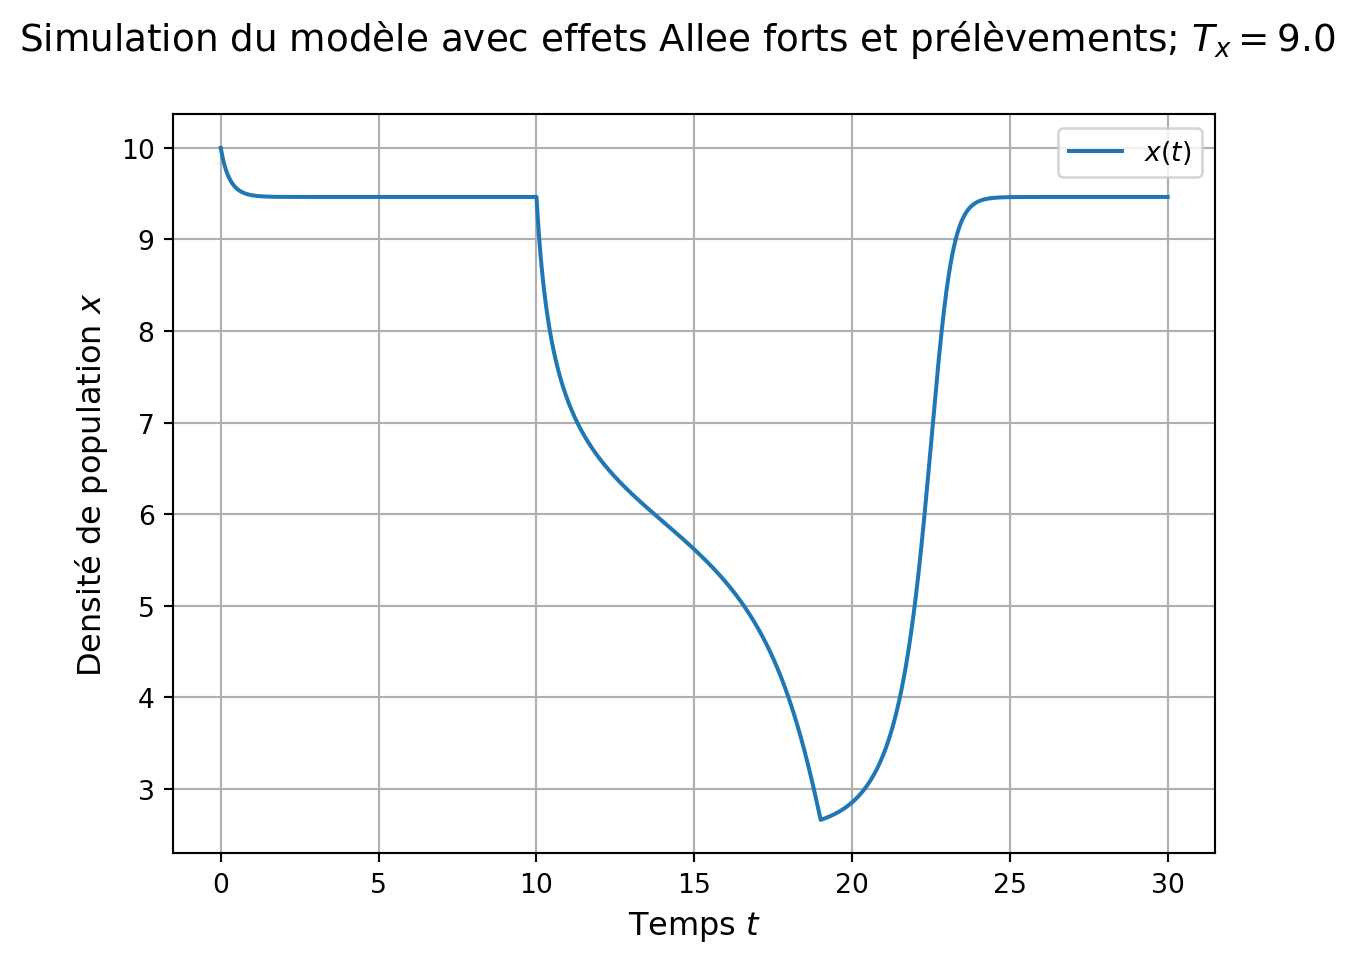

In [9]:
#| label: fig-alleeprelev1
#| code-fold: true
#| fig-cap: simulation du modèle avec effets Allee forts et prélèvements (@eq-alleeprelev)
fig1, ax1 = plt.subplots(1, 1)  
fig1.suptitle('Simulation du modèle avec effets Allee'\
    ' forts et prélèvements; $T_x={}$'.format(T_x), 
              va='top', fontsize='14')

## simulation
ax1.plot(tspan, int_alleePrelev,
        label = "$x(t)$")

## axes / légendes / grille
ax1.legend(fontsize='10')
ax1.set_xlabel('Temps $t$', fontsize='12')
ax1.set_ylabel('Densité de population $x$', fontsize='12')
ax1.grid()

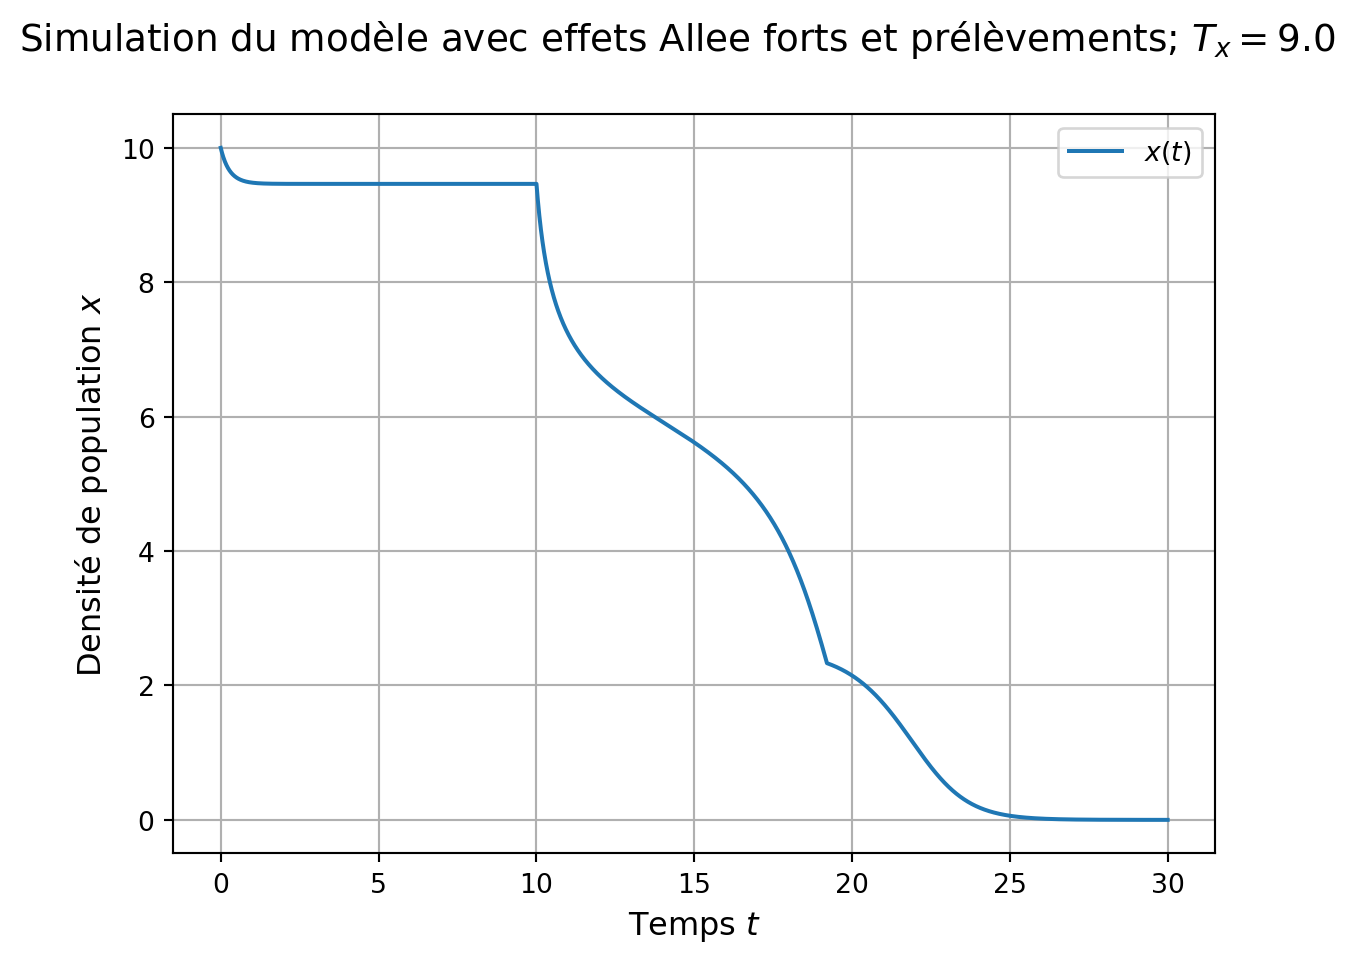

In [10]:
#| label: fig-alleeprelev2
#| code-fold: true
#| fig-cap: simulation du modèle avec effets Allee forts et prélèvements (@eq-alleeprelev)

## redefinition de T_x et des paramètres
T_x2 = 9.2
params_Evar2 = np.array([E_s, E_x, T_s, T_x2])

## intégration
int_alleePrelev2 = odeint(model_alleePrelev,
                         x0,
                         tspan,
                         args=(params_allee, params_Evar2),
                         hmax=pas_t)

fig2, ax2 = plt.subplots(1, 1)  
fig2.suptitle('Simulation du modèle avec effets Allee forts '\
    'et prélèvements; $T_x={}$'.format(T_x), 
              va='top', fontsize='14')

## simulation
ax2.plot(tspan, int_alleePrelev2,
        label = "$x(t)$")

## axes / légendes / grille
ax2.legend(fontsize='10')
ax2.set_xlabel('Temps $t$', fontsize='12')
ax2.set_ylabel('Densité de population $x$', fontsize='12')
ax2.grid()

In [11]:
#| code-fold: true

## définition de vecteurs annexes E_plot et x_plot 
E_plot = np.arange(0, 1, 0.01)
x_plot_l = np.arange(epsilon, (K+epsilon)/2, 0.01)
x_plot_L = np.arange((K+epsilon)/2, K, 0.01)

## définition des valeurs de E correspondant aux équilibres positifs
E_eq_l = r*(x_plot_l/epsilon-1)*(1-x_plot_l/K)
E_eq_L = r*(x_plot_L/epsilon-1)*(1-x_plot_L/K)

## création d'une figure, et de deux subplots (ax6, ax7)
fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(9, 6))  

## titre de la figure
fig2.suptitle('Effet Allee forts et prèlevements\n '\
    '$T_x$ = {} (gauche), $T_x$ = {} (droite)'
              .format(T_x, T_x2), va='top', fontsize='14')

## premier subplot
## tracé du lieu des équilibres
ax3.plot(E_plot, np.zeros_like(E_plot), color = 'C2')
ax3.plot(E_eq_L, x_plot_L, color='C2', label='équilibre stable')
ax3.plot(E_eq_l, x_plot_l, color='C3', label='équilibre instable')

## labellisation des axes
ax3.set_xlabel('effort de prélèvement $E$', fontsize='12')
ax3.set_ylabel('densité de population $x$', fontsize='12')
ax3.grid()

## second subplot
## tracé du lieu des équilibres
ax4.plot(E_plot, np.zeros_like(E_plot), color = 'C2')
ax4.plot(E_eq_L, x_plot_L, color='C2', label='équilibre stable')
ax4.plot(E_eq_l, x_plot_l, color='C3', label='équilibre instable')

## labellisation des axes
ax4.set_xlabel('effort de prélèvement $E$', fontsize='12')
ax4.grid()

plt.close(fig2)

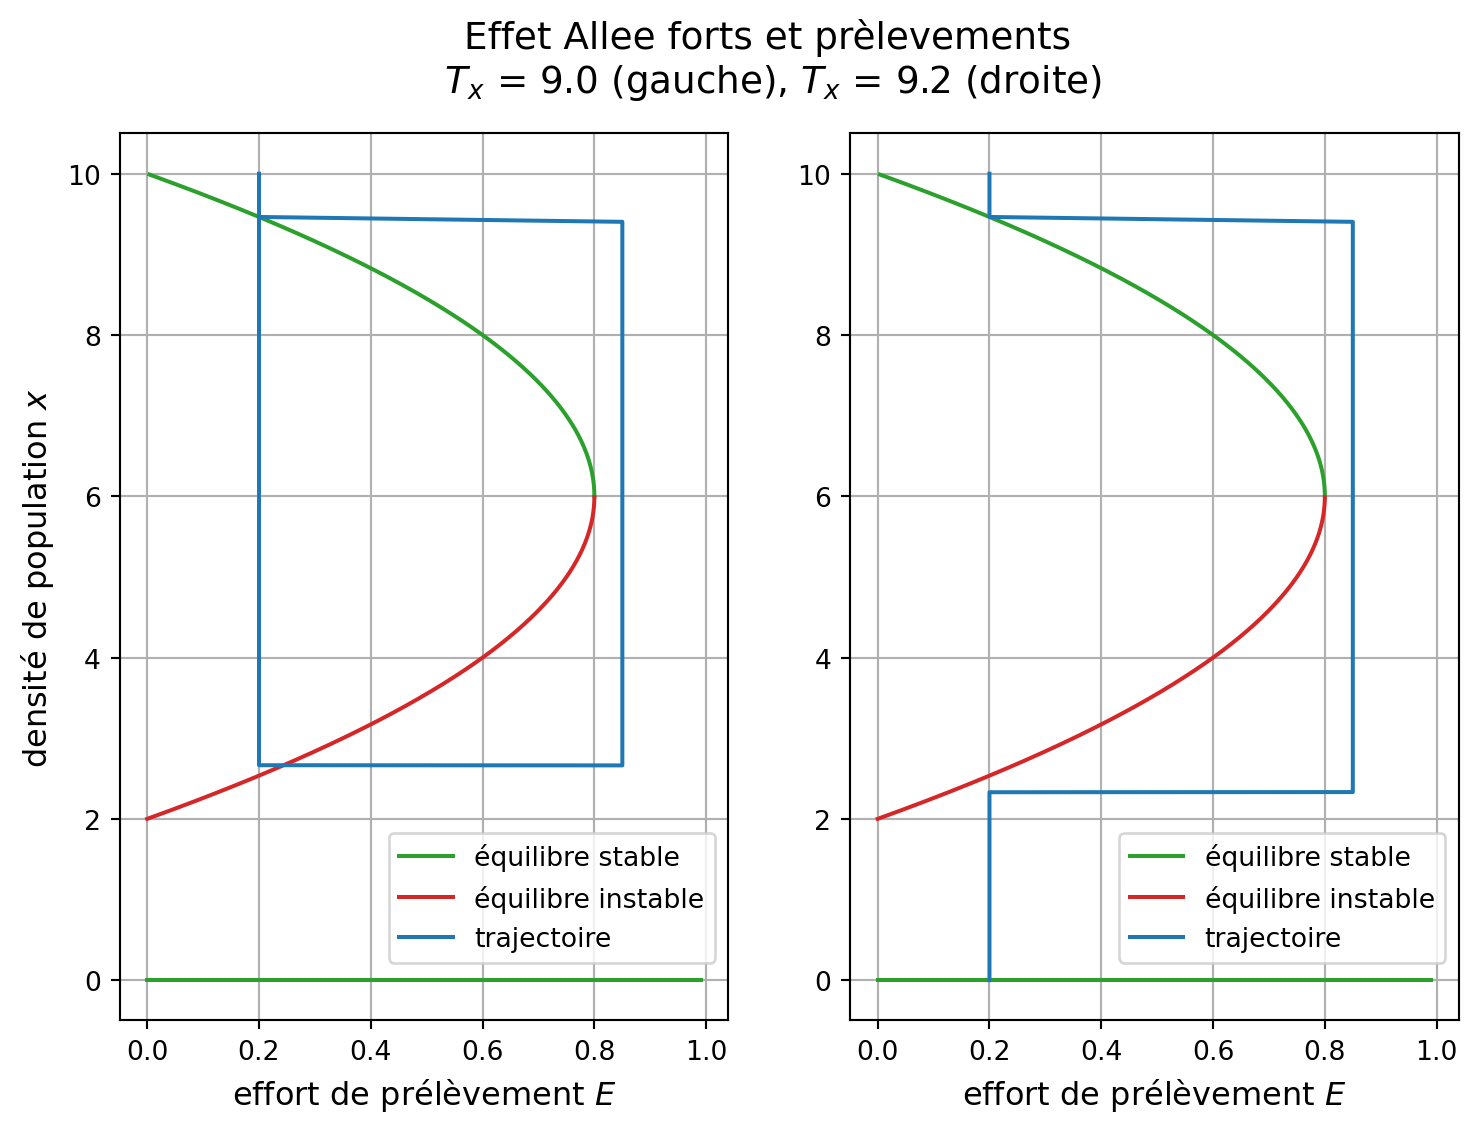

In [12]:
#| label: fig-alleebif
#| fig-cap: bifurcation pli et catastrophe dans le modèle avec effet Allee et prélèvements

## premier subplot
ax3.plot([Evar(t, params_Evar) for t in tspan], int_alleePrelev, 
         color = 'C0', label = 'trajectoire')
ax3.legend(fontsize='10', loc = 'lower right', 
           bbox_to_anchor=(0.5, 0.05, 0.5, 0.5))

## second subplot
ax4.plot([Evar(t, params_Evar2) for t in tspan], int_alleePrelev2, 
         color = 'C0', label = 'trajectoire')
ax4.legend(fontsize='10', loc = 'lower right', 
           bbox_to_anchor=(0.5, 0.05, 0.5, 0.5))

display(fig2)

In [13]:
#| code-fold: true
## on nettoie l'espace de travail et on reload les modules
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## tspan
t_0 = 0             
t_fin = 3.0        
pas_t = 0.01
tspan = np.arange(t_0, t_fin, pas_t)

## paramètres du modèle
r = 5.0
K = 10.0
alpha = 1.0
h = 0.5
y_c = 7.0
params_tordeuse_yc = np.array([r, K, alpha, h, y_c])

## définition du modèle tordeuse avec pop oiseaux constante
def model_tordeuse_yc(etat, t, params): 
    x = etat              # on recupere l'etat
    r, K, alpha, h, y_c = params     # on récupère les paramètres
    xdot = r*x*(1-x/K) - alpha*(x**2)*y_c/((h**2)+(x**2))    # la derivee 
    return xdot           # on renvoie la derivée calculée

In [14]:
#| code-fold: true

def int_tordeuse(x0, tspan=tspan, params=params_tordeuse_yc):
    sim_tordeuse = odeint(
                model_tordeuse_yc,        
                x0,              
                tspan,           
                args=(params,),  
                hmax=pas_t)
    return sim_tordeuse

## multi-conditions initiales
x0_step = 1.35
x0_arr = np.arange(x0_step, K, x0_step)

In [15]:
#| code-fold: true

fig, ax = plt.subplots(1, 1)  
fig.suptitle('Simulation du modèle de tordeuse avec population'\
    ' d\'oiseaux constante', 
              va='top', fontsize='14')

## redéfinition du cycle des couleurs pour un dégradé de bleu
colorTordeuse = plt.cm.Blues(np.linspace(.8, .3, x0_arr.shape[0]))
ax.set_prop_cycle(color = colorTordeuse)

## simulations
ax.plot(tspan, int_tordeuse(x0_arr[0]),
        label = "$x(t)$")
for x0 in x0_arr[1:]:       # x0 parcour x0_arr
    ax.plot(tspan, int_tordeuse(x0)) 

## équilibres
ax.plot(tspan, np.zeros_like(tspan),
        color = 'C3',
        linestyle = 'dashed',
        label = "équilibre instable")

## axes / légendes / grille
ax.set_xlabel('Temps $t$', fontsize='12')
ax.set_ylabel('Densité de population $x$', fontsize='12')
ax.grid()
plt.close(fig)

In [16]:
## monôme de degré 1
z = np.polynomial.Polynomial([0, 1])

## polynome dont les racines sont les x* > 0
pol = r*(1-z/K)*(h**2+z**2)-alpha*z*y_c

## on calcule les racines et on récupère seulement les réelles, > 0 et < K
eq_pos = pol.roots()[(np.isreal(pol.roots())) 
            * (pol.roots() < K) * (pol.roots() > 0)] 

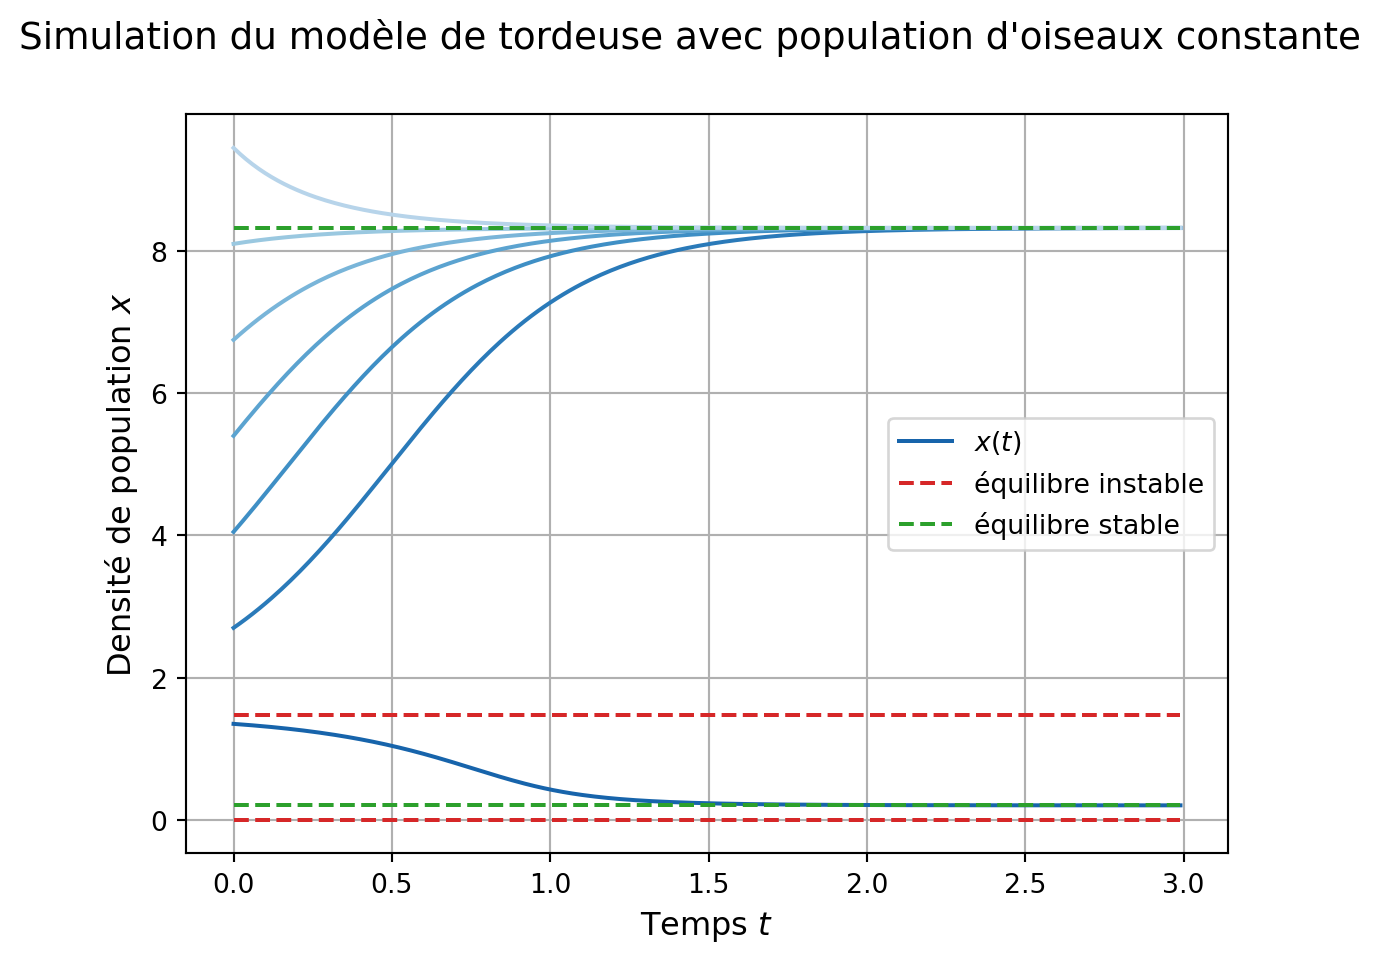

In [17]:
#| label: fig-tordeuse-yc
#| fig-cap: 'simulation du modèle de tordeuse, population d''oiseaux constante (@eq-tordeuse)'

## d'après l'étude mathématique, on s'attend à 1 ou 3 équilibres positifs
if eq_pos.size == 1:
    ax.plot(tspan, np.ones_like(tspan)*eq_pos, 
            color='C2', label ="équilibre stable")

elif eq_pos.size == 3:
    ax.plot(tspan, np.ones_like(tspan)*eq_pos[0], 
            linestyle = 'dashed', color='C2', label='équilibre stable')
    ax.plot(tspan, np.ones_like(tspan)*eq_pos[1], 
            linestyle = 'dashed', color='C3')
    ax.plot(tspan, np.ones_like(tspan)*eq_pos[2], 
            linestyle = 'dashed', color='C2')

ax.legend(fontsize='10')
display(fig)

In [18]:
## équilibres positifs
## on récupère les extrema du lieu des équilibres positifs 
from sympy import Symbol, solve, Derivative, re
x = Symbol('x')
## lieu des équilibres
yfunc = r*(1-x/K)*(h**2+x**2)/(alpha*x)
## dérivée
dyfunc = Derivative(yfunc, x).doit()
## points critiques positifs. 
## solve() renvoit ici des complexes avec partie Im. presque nulles
crit_points = [re(root) for root in solve(dyfunc) if re(root)>0]

## on calcule chacune des branches
xplot1 = np.arange(0.01, crit_points[0], 0.01)
xplot2 = np.arange(crit_points[0], crit_points[1], 0.01)
xplot3 = np.arange(crit_points[1], K, 0.01)
yeq1 = r*(1-xplot1/K) / (alpha*xplot1)*(h**2+xplot1**2)
yeq2 = r*(1-xplot2/K) / (alpha*xplot2)*(h**2+xplot2**2)
yeq3 = r*(1-xplot3/K) / (alpha*xplot3)*(h**2+xplot3**2)

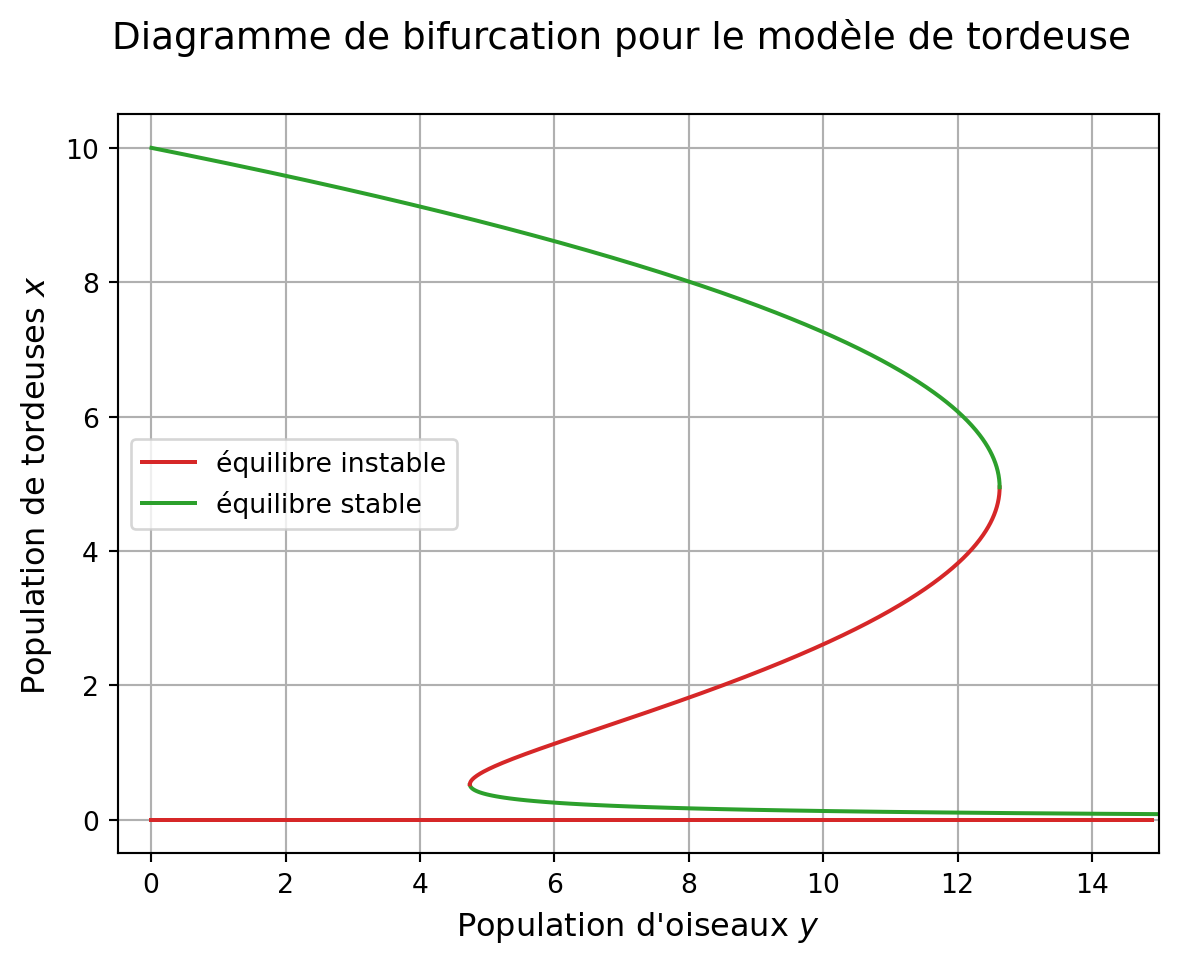

In [19]:
#| label: fig-tordeuxe-bif
#| fig-cap: diagramme de bifurcation pour l'@eq-tordeuse en fonction de la taille de population d'oiseaux
#| code-fold: true

fig2, ax2 = plt.subplots(1, 1)

fig2.suptitle('Diagramme de bifurcation pour le modèle'\
    ' de tordeuse', 
              va='top', fontsize='14')

## équilibre nul
yplot = np.arange(0, 15, 0.1)
ax2.plot(yplot, np.zeros_like(yplot), color = "C3", label = "équilibre instable")

## équilibres positifs
ax2.plot(yeq1, xplot1, color='C2', label='équilibre stable')
ax2.plot(yeq2, xplot2, color='C3')
ax2.plot(yeq3, xplot3, color='C2')

## bornes abscisses
ax2.set_xlim(left = -.50, right = 15)

ax2.set_ylabel('Population de tordeuses $x$', fontsize='12')
ax2.set_xlabel('Population d\'oiseaux $y$', fontsize='12')
ax2.legend(loc='center left')
ax2.grid()

In [20]:
def model_tordeuse_yvar(etat, t, params):
    x, y = etat                                 # recupere les variables d'etat
    r, K, alpha, h, epsilon, n, m = params      # recupere les parametres 
    etatdot = [r*x*(1 - x/K) - alpha*x**2/(h**2+x**2)*y,   # dot x
               epsilon*(n*alpha*x**2/(h**2+x**2)-m)*y]     # dot y

    return etatdot                                      # renvoit la derivee

In [21]:
## densités initiales de populations
x0 = 1
y0 = 2.5
etat0_tordeuse_yvar = np.array([x0, y0]) # encapsulation 

## tspan
tfin_yvar = 400.0
tspan_yvar = np.arange(0.0, tfin_yvar, pas_t)

## paramètres spécifiques à la population d'oiseaux
epsilon = 0.01
n = 5.0
m = 3.0
params_tordeuse_yvar = np.array([r, K, alpha, h, epsilon, n, m])

In [22]:
int_tordeuse_yvar = odeint(
                        model_tordeuse_yvar, 
                        etat0_tordeuse_yvar, 
                        tspan_yvar, 
                        args=(params_tordeuse_yvar,),
                        hmax=pas_t)

In [23]:
int_tordeuse_yvar[:5,]

array([[1.        , 2.5       ],
       [1.02540404, 2.50025497],
       [1.05163666, 2.50051974],
       [1.07872903, 2.50079407],
       [1.10671295, 2.50107772]])

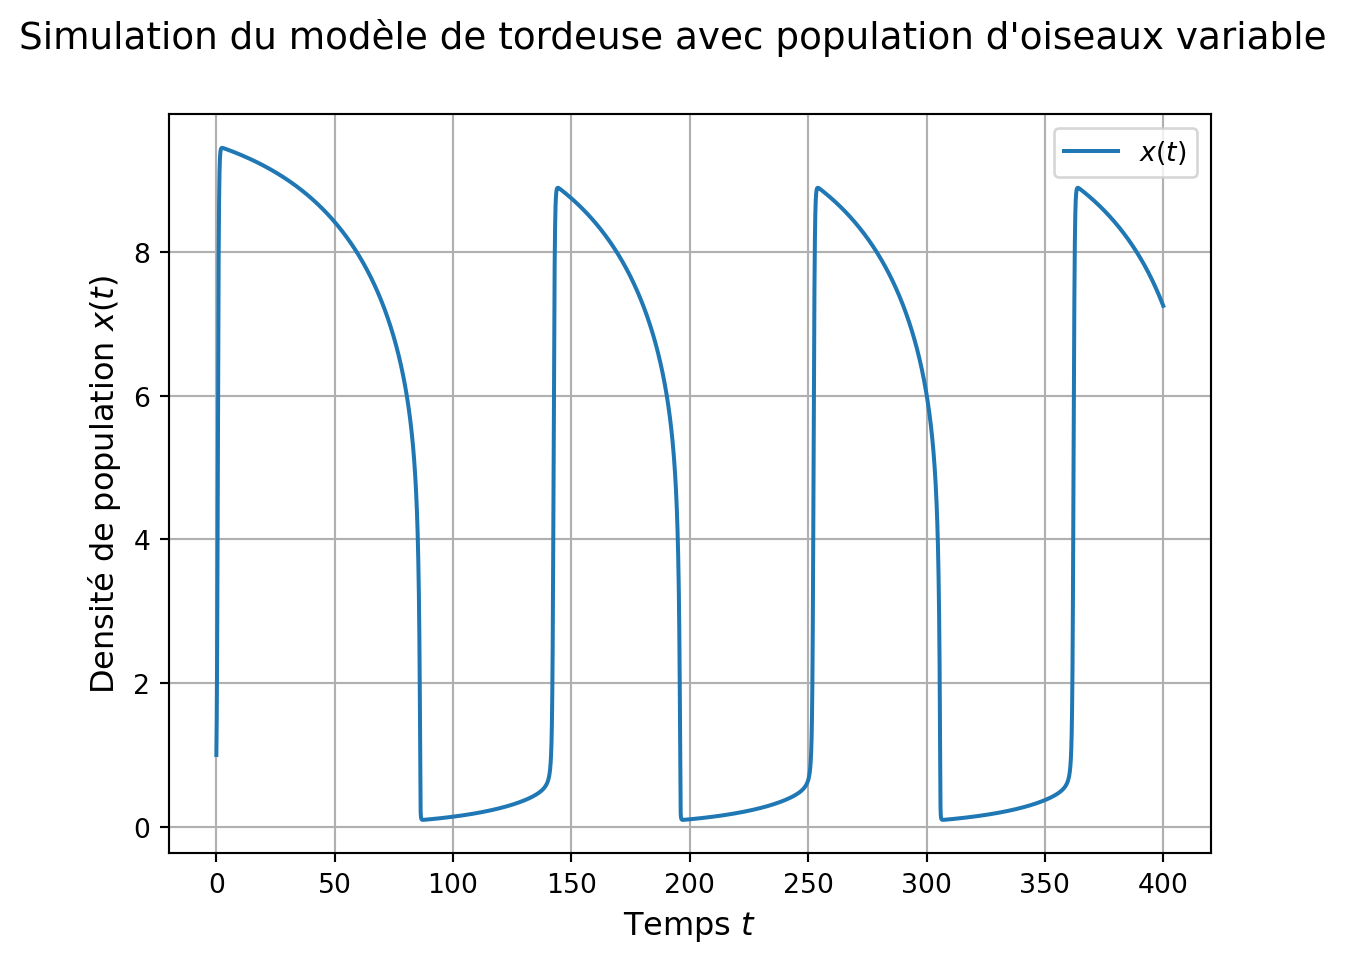

In [24]:
#| code-fold: true
#| label: fig-tordeuse-yvar
#| fig-cap: Simulation du modèle de tordeuse avec population d'oiseaux variables @eq-tordeuse-yvar

fig3, ax3 = plt.subplots(1, 1)  
fig3.suptitle('Simulation du modèle de tordeuse'\
    ' avec population d\'oiseaux variable', 
              va='top', fontsize='14')

## simulations
ax3.plot(tspan_yvar, int_tordeuse_yvar[:,0], 
        color = 'C0',
        label = "$x(t)$")

## axes / légendes / grille
ax3.set_xlabel('Temps $t$', fontsize='12')
ax3.set_ylabel('Densité de population $x(t)$', fontsize='12')
ax3.legend()
ax3.grid()

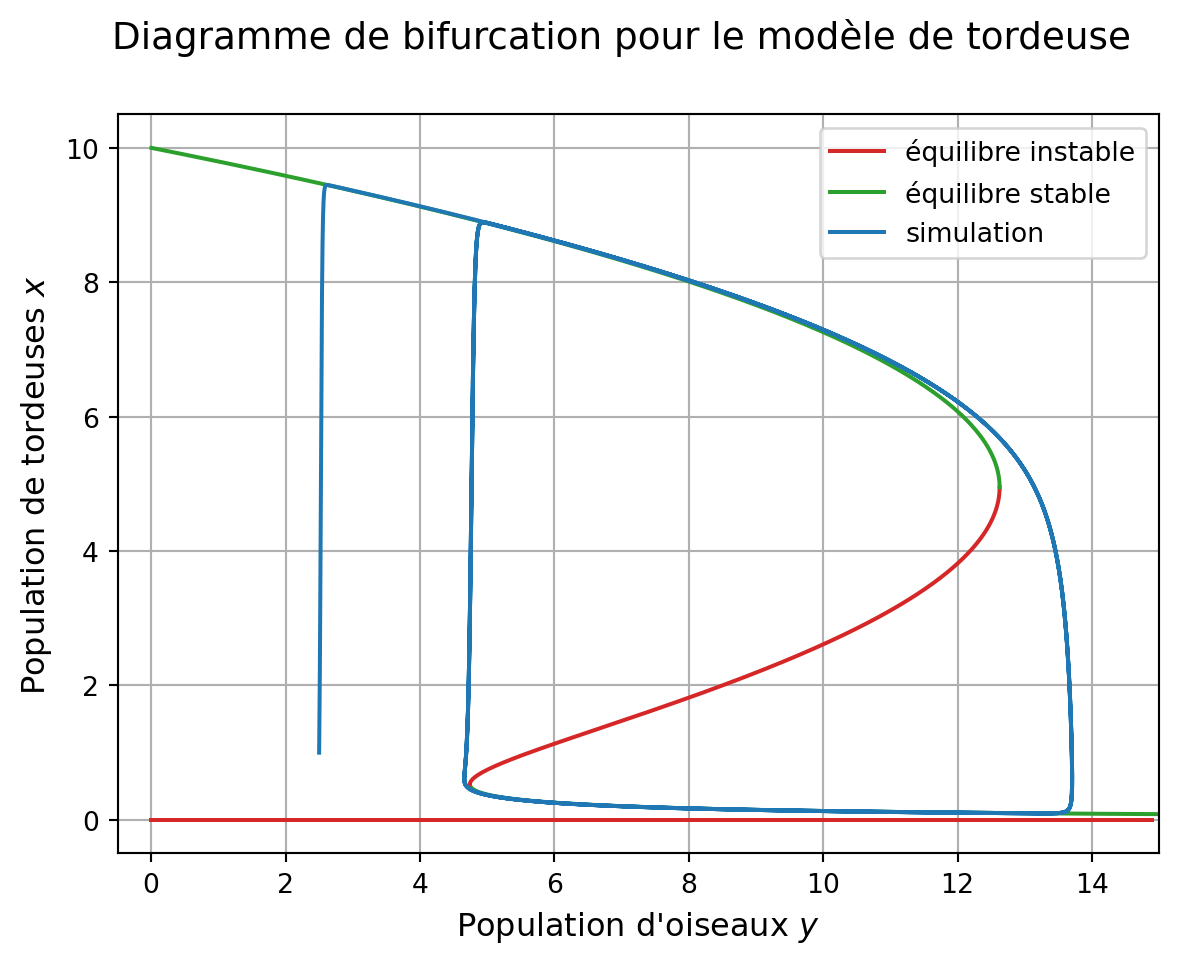

In [25]:
#| code-fold: true
#| label: fig-tordeuse-yvar-bif
#| fig-cap: Bifurcations dynamiques dans le modèle de tordeuse avec population d'oiseaux variables @eq-tordeuse-yvar
fig2.suptitle('Diagramme de bifurcation pour le modèle de tordeuse', 
              va='top', fontsize='14')

ax2.plot(int_tordeuse_yvar[:,1], int_tordeuse_yvar[:,0], label='simulation')
ax2.legend()
display(fig2)